In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess
from tqdm import tqdm_notebook
import pprint
import librosa
from IPython.display import clear_output
from scipy.ndimage import convolve
import music21
import madmom
from scipy.signal import convolve2d
from scipy.stats import linregress
from multiprocessing import Pool
import yaml
import functools

from msmd.midi_parser import notes_to_onsets, FPS
from msmd.data_model.piece import Piece
from msmd.alignments import align_score_to_performance

In [54]:
# path to MSMD dataset
DATA_ROOT_MSMD = '../msmd_aug/msmd_aug'

In [55]:
# Clear bootlegs
files = glob.glob(os.path.join(DATA_ROOT_MSMD, '*', '*', '*', 'output.npy'))
for file in files:
    os.remove(file)

In [56]:
# obtain all the pieces in the dataset
with open('../msmd/msmd/splits/all_split.yaml', 'r') as f:
    doc = yaml.load(f)
    
pieces = doc['test']
assert len(pieces) == 100

In [57]:
def extractStrips(mungos_per_page):
    """
    Extract a list of staves' mungos objects.
    
    Input: 
        mungos_per_page - a list of mungos per page
        
    Output:
        strips - a list of (page, system_mungo) indicating each strip in sequential order.
        where 
            page = page number
            system_mungo = a mungo for a staff
    """
    strips = []
    minWidth = np.inf
    
    page_num = len(mungos_per_page)
    for page in range(page_num):
        system_mungos = [c for c in mungos_per_page[page] if c.clsname == 'staff']
        system_mungos = sorted(system_mungos, key=lambda m: m.top)
        for system_mungo in system_mungos:
            strips.append((page, system_mungo))
            minWidth = min(minWidth, system_mungo.width)
    return strips, minWidth

In [58]:
def convertMungoToImage(system_mungo, image, 
                        stripWidth,
                        marginTopRatio=0.45, 
                        marginBottomRatio=0.45,
                        verbose=False):
    """
    Convert staff location information from mungo to an actual image.
    
    Input:
        system_mungo - mungo for a staff line
        image - an image of the page corresponding to the system_mungo
        
    Output:
        image - an image in np.array whose values are np.int8
    
    """
    
    # Get the bounding box of the staff
    (y_top, x_left, y_bottom, x_right) = system_mungo.bounding_box
    height = y_bottom - y_top
    width = x_right - x_left
    
    # Calculate the vertical margins
    marginTop = min(int(round(marginTopRatio * height)), y_top)  #  Prevent out-of-page margin
    marginBottom = min(int(round(marginBottomRatio * height)), image.shape[0] - y_bottom) #  Prevent out-of-page margin
     
    # Calculate the starting and ending vertical positions
    y_start = y_top - marginTop
    y_end = y_bottom + marginBottom
       
    # Calculate the starting and ending horizontal positions
    x_start = x_left
    x_end = x_left + stripWidth
    
    if verbose:
        plt.imshow(image[y_start:y_end,x_start:x_end], cmap="gray")
        plt.show()
        
    return image[y_start:y_end, x_start:x_end]

In [59]:
def ReLU(x):
    return x * (x > 0)

In [60]:
def fitStaffLines(scores, height):
    N = len(scores)
    idx_RH, idx_LH, best_score = 0, 0, -1
    idxs_sorted = np.argsort(scores)[::-1]
    min_separation = int(height * 1.66)
    idx1 = idxs_sorted[0]
    for j in range(1, N):
        idx2 = idxs_sorted[j]
        curScore = scores[idx1] + scores[idx2]
        sep = np.abs(idx1 - idx2)
        if sep > min_separation and curScore > best_score:
            best_score = curScore
            idx_RH = min(idx1, idx2)
            idx_LH = max(idx1, idx2)
            break
    return best_score, idx_RH, idx_LH

def locateStaffLines(s, min_height = 5, max_height = 50, plot = True):
    rsums = np.sum(s, axis=1)
    bestScore = 0
    lineLocs = np.zeros(10)
    for h in range(min_height,max_height+1):
        idxs = h * np.arange(5) / 4.0
        idxs = idxs.round().astype('int')
        filt = np.zeros(h+1)
        filt[idxs] = 1 # create comb filter
        scores = np.convolve(rsums, filt, 'valid')
        curScore, idx_RH, idx_LH = fitStaffLines(scores, h)
        if curScore > bestScore:
            bestScore = curScore
            lineLocs[0:5] = idxs + idx_RH
            lineLocs[5:] = idxs + idx_LH
    
    if plot:
        plt.plot(rsums)
        for i in range(len(lineLocs)):
            plt.axvline(x=lineLocs[i], color='r', linewidth=1)
        plt.show()
        
    return lineLocs

In [64]:
def computeOnsetLikelihood(spectrogram):
    """
    Compute onset likelihood based on the given spectrogram
    """
    output = np.zeros_like(spectrogram)
    output[:,0] = spectrogram[:,0]
    output[:,1:] = ReLU(spectrogram[:,1:] - spectrogram[:,:-1])

    mv_mean = convolve(output, np.ones((1,5))/5, mode='constant')
    smoothed = ReLU(output - mv_mean)
    return smoothed

In [65]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s' % hand)
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [66]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

In [67]:
def generateNoteImpulses(onset_spec, strip, m, b, total_length):
    factor = int(np.ceil(total_length / onset_spec.shape[1]))
    synthLen = factor * onset_spec.shape[1]
    impulses = np.zeros((strip.shape[0], synthLen))
    
    for r in range(onset_spec.shape[0]):
        MIDI_num = r + 21
        row = estimatePixelRow(MIDI_num, m, b)
        for timeIdx in range(0,onset_spec.shape[1]):
            if row >= 0 and row < strip.shape[0]:
                impulses[row, factor * timeIdx] = (onset_spec[r, timeIdx] / np.max(onset_spec)) ** 2
    return impulses

In [68]:
def adjustMidiTiming(noteImpulses, maxPauseLen = 50):
    
    # identify long pauses where no onsets occur
    csums = np.sum(noteImpulses, axis=0)   
    dataToInsert = [] # either the index of the column to insert, or -1 for a column of zeros
    isPause = False
    markerStart = 0
    for i in range(len(csums)):
        if isPause:
            if csums[i] != 0 or i == len(csums) - 1: # in a pause, notes occur
                pauseLen = i - markerStart
                if pauseLen > maxPauseLen:
                    dataToInsert.extend([-1] * maxPauseLen)
                else:
                    dataToInsert.extend([-1] * pauseLen)
                dataToInsert.append(i)
                isPause = False
            else: # in a pause, no notes occur
                pass
        else:
            if csums[i] != 0: # not a pause, notes occur
                dataToInsert.append(i)
            else: # not a pause, no notes occur
                isPause = True
                markerStart = i
    
    # reconstruct onset data
    adjusted = np.zeros_like(noteImpulses)
    # Original:    adjusted = np.zeros((noteImpulses.shape[0],len(dataToInsert)))
    for i, col in enumerate(dataToInsert):
        if col == -1:
            pass # leave as zeros
        else:
            adjusted[:,i] = noteImpulses[:,col]
    return adjusted, dataToInsert

In [69]:
def zeroPadColumns(X, nBefore, nAfter):
    h = X.shape[0]
    Y = np.hstack((np.zeros((h,nBefore)), X, np.zeros((h,nAfter))))
    return Y

In [70]:
def get2DFilter(m):
    filt_sz = np.int(np.round(np.abs(m) * 4))
    filt2d = getBlurFilter(filt_sz, 'block')
    return filt2d

In [71]:
def getBlurFilter(sz, filterType):
    if filterType == 'hamming':
        filt = np.matmul(np.hamming(sz).reshape((sz,1)), np.hamming(sz).reshape(1,sz))
    elif filterType == 'circle':
        filt = np.zeros((sz,sz))
        center = sz/2
        for i in range(sz):
            for j in range(sz):
                if np.sqrt((i-center)*(i-center)+(j-center)*(j-center)) <= center - .01:
                    filt[i,j] = 1
    elif filterType == 'block':
        filt = np.ones((np.int(1.2*sz),np.int(1.125*sz)))
    else:
        print('Unrecognized filter type: %s' % filterType)
        sys.exit(1)
    return filt

In [74]:
def generateBootleg(piece_idx, salient=False, debug=False):
    piece = pieces[piece_idx]
    
    # Load the score
    msmd_piece = Piece(root=DATA_ROOT_MSMD, name=piece)
    assert len(msmd_piece.available_scores) > 0
    
    score = msmd_piece.load_score(msmd_piece.available_scores[0])
    # Load image
    images = score.load_images()
    # Load mungos
    mungos = score.load_mungos()
    mdict = {m.objid: m for m in mungos}
    mungos_per_page = score.load_mungos(by_page=True)
    
    # Extract strips from page
    strips, minWidth = extractStrips(mungos_per_page)
    strip_images = list(map(lambda x: convertMungoToImage(x[1], images[x[0]], minWidth), strips))
    
    # Verify that all strips have the same width
    for strip_image in strip_images[1:]:
        assert strip_images[0].shape[1] == strip_image.shape[1]
    
    # Extract staff lines
    staff_lines = []
    for strip_image in strip_images:
        lines = locateStaffLines(255 - strip_image, min_height=20, max_height=50, plot=False)
        staff_lines.append(lines)
    
    performances = glob.glob(os.path.join(DATA_ROOT_MSMD, piece, 'performances', '*tempo-1000_grand-piano-YDP-20160804*'))
    pbar_performances = tqdm_notebook(total=len(performances), leave=False)
        
    for performance in performances:    
        pbar_performances.set_description("Processing {}".format(performance))
        if len(glob.glob(os.path.join(performance, 'spec', '*_spec.npy'))) == 0:
            print('Invalid Piece {}'.format(piece))
            break
            
        spec_file = glob.glob(os.path.join(performance, 'spec', '*_spec.npy'))[0]
        
        # Compute note onsets
        spec = np.load(spec_file)
        
        if salient:
            # Compute salience representation
            # Construct a summing filter at 8 harmonic locations
            filt = np.zeros((spec.shape[0],1))
            filt[np.round(12 * np.log2(np.arange(1,8))).astype(np.int)] = 1

            # Compute the harmonic summation
            spec = np.flipud(convolve2d(np.flipud(spec), filt, mode='full'))[spec.shape[0]-1:]
        
        onsets = computeOnsetLikelihood(spec)
        
        # analyze the strip
        total_length = sum(list(map(lambda x: x.shape[1], strip_images)))
        
        # Create bootleg for each strip
        Cblocks = []
        synths = []
        zeroPad = 50
        
        pbar_k = tqdm_notebook(total=len(strip_images), leave=False)
        
        for k in range(len(strip_images)):
            pbar_k.set_description('Working on strip {}/{}'.format(k, len(strip_images)))
            strip = 255 - strip_images[k]
            
            lines = staff_lines[k]
            breakpt = np.int(np.round(.5 * (lines[4] + lines[5])))
            upper = strip[0:breakpt, :]
            lower = strip[breakpt:, :]
            m1, b1 = estimateMidiNum2PixelRowMapping(upper, lines[0:5], 'right')
            m2, b2 = estimateMidiNum2PixelRowMapping(lower, lines[5:10] - breakpt, 'left')

            # synthesis
            impulses1 = generateNoteImpulses(onsets, upper, m1, b1, total_length)
            impulses2 = generateNoteImpulses(onsets, lower, m2, b2, total_length)
            impulses = np.vstack((impulses1, impulses2))
            timeAdjusted, timeMapping = adjustMidiTiming(impulses)
            zeroPadded = zeroPadColumns(timeAdjusted, zeroPad, zeroPad)
            filt2d = get2DFilter(np.mean([np.abs(m1),np.abs(m2)]))    
            blurred = convolve2d(zeroPadded, filt2d, 'same')
            stavesTemplate = np.matlib.repmat(np.median(strip, axis=1).reshape(-1,1), 1, blurred.shape[1])
            withLines = np.clip(blurred + stavesTemplate, 0, 1)

            synths.append(withLines)
            
            s1 = strip
            s2 = withLines
            
            costBlock = -1.0 * np.matmul(s1.T, s2)
            Cblocks.append(costBlock)
            
            # Update progress bar
            pbar_k.update(1)
        
        pbar_k.close()
        
        C = np.vstack(Cblocks)
        
        # DTW
        steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
        weights = np.array([2,3,3])
        
        D, wp = librosa.core.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights, subseq=False)
        wp = wp[::-1,:]
        
        output_file_path = os.path.join(performance, 'output.npy')
        
        if os.path.exists(output_file_path):
            output = np.load(output_file_path).item()
        else:
            output = {}
            
        if salient: output['wp-salient'] = wp
        else:       output['wp'] = wp
        output['zeroPad'] = zeroPad
        output['factor'] = (C.shape[1] - 2*zeroPad) // spec.shape[1]
        
        np.save(output_file_path, output)
        
        # Update progress bar
        pbar_performances.update(1)
    pbar_performances.close()
    
    # Visualize
    if debug:
        maxH = np.max([s.shape[0] for s in strip_images])
        pan1 = np.zeros((maxH, wp.shape[0]))
        cumStripLens = np.cumsum([0] + [s.shape[1] for s in strip_images])
        col2strip = [i for i, s in enumerate(strip_images) for j in range(s.shape[1])] # column index -> strip index
        for i in range(wp.shape[0]):
            globalIdx = wp[i,0]
            stripIdx = col2strip[globalIdx]
            h = strip_images[stripIdx].shape[0]
            localIdx = globalIdx - cumStripLens[stripIdx]
            pan1[0:h,i] = strip_images[stripIdx][:, localIdx] /255
        pan2 = np.zeros((maxH, wp.shape[0]))
        for i in range(wp.shape[0]):
            sheetColIdx = wp[i,0]
            midiColIdx = wp[i,1]
            stripIdx = col2strip[sheetColIdx]
            h = synths[stripIdx].shape[0]
            pan2[0:h, i] = synths[stripIdx][:,midiColIdx]
        
        if not os.path.exists(os.path.join(DATA_ROOT_MSMD, 'output')):
            os.mkdir(os.path.join(DATA_ROOT_MSMD, 'output'))
        
        if not os.path.exists(os.path.join(DATA_ROOT_MSMD, 'output', piece)):
            os.mkdir(os.path.join(DATA_ROOT_MSMD, 'output', piece))
       
        output_file_path = os.path.join(DATA_ROOT_MSMD, 'output', piece, 'pan1.npy')
        np.save(output_file_path, pan1)
        output_file_path = os.path.join(DATA_ROOT_MSMD, 'output', piece, 'pan2.npy')
        np.save(output_file_path, pan2)

In [75]:
piece_idx = 1
generateBootleg(piece_idx, salient=False, debug=True)

In [ ]:
with Pool(12) as p:
    list(tqdm_notebook(p.imap(functools.partial(generateBootleg, 
                                                debug=True,
                                                salient=False), 
                              range(len(pieces))), total=len(pieces)))

In [ ]:
with Pool(12) as p:
    list(tqdm_notebook(p.imap(functools.partial(generateBootleg, 
                                                debug=True,
                                                salient=True), 
                              range(len(pieces))), total=len(pieces)))

In [83]:
pan1 = np.load(os.path.join(DATA_ROOT_MSMD, 'output', pieces[piece_idx], 'pan1.npy'))
pan2 = np.load(os.path.join(DATA_ROOT_MSMD, 'output', pieces[piece_idx], 'pan2.npy'))

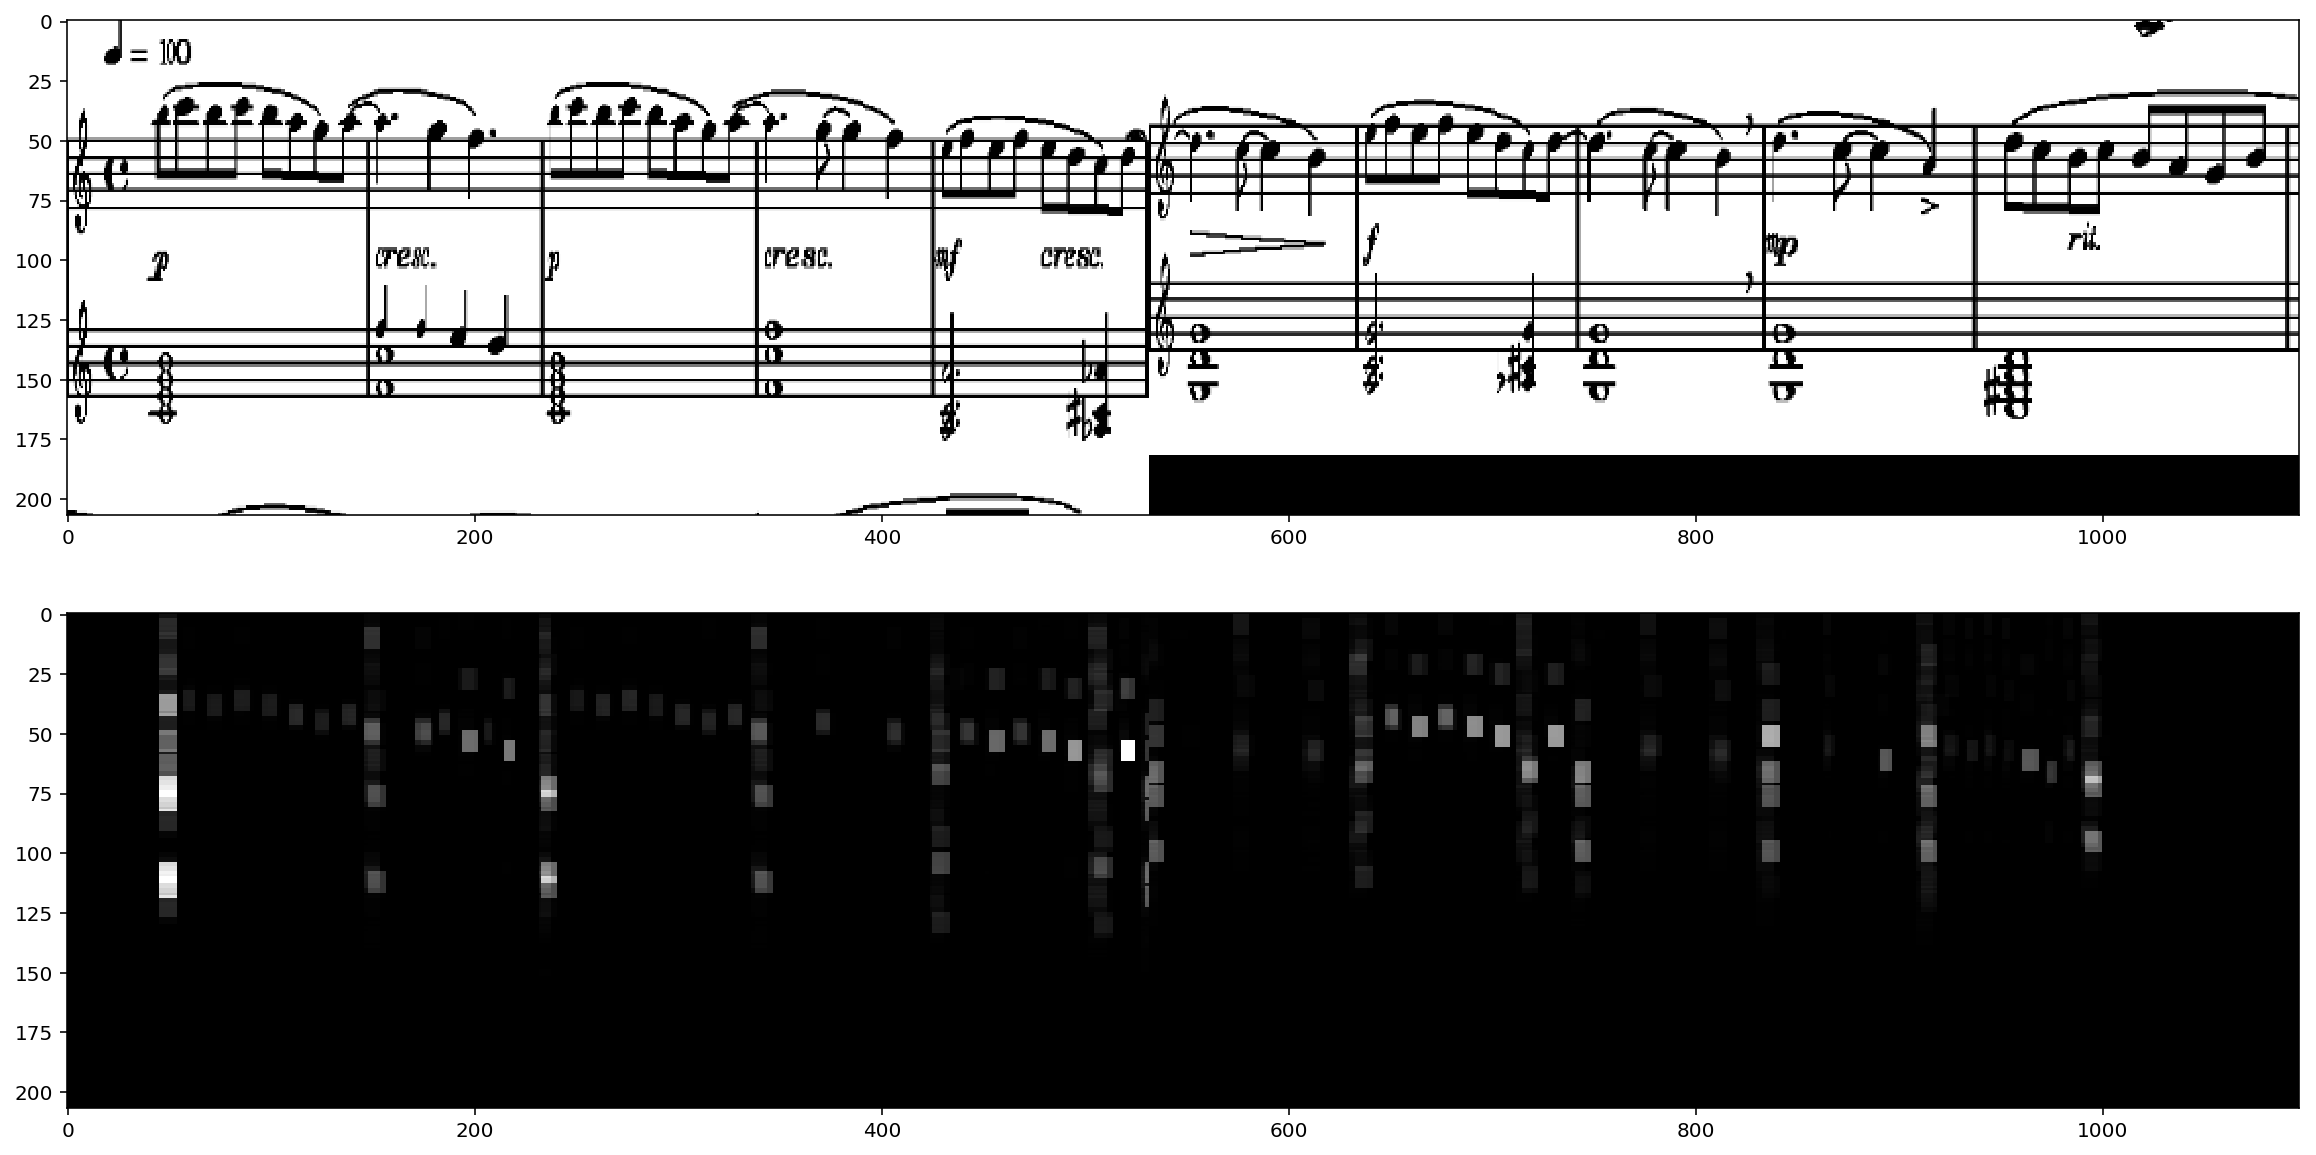

In [84]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(pan1, aspect='auto', cmap='gray')
plt.subplot(2,1,2)
plt.imshow(pan2, aspect='auto', cmap='gray')
plt.show()

In [87]:
pan1 = np.load(os.path.join(DATA_ROOT_MSMD, 'output', pieces[piece_idx], 'pan1.npy'))
pan2 = np.load(os.path.join(DATA_ROOT_MSMD, 'output', pieces[piece_idx], 'pan2.npy'))

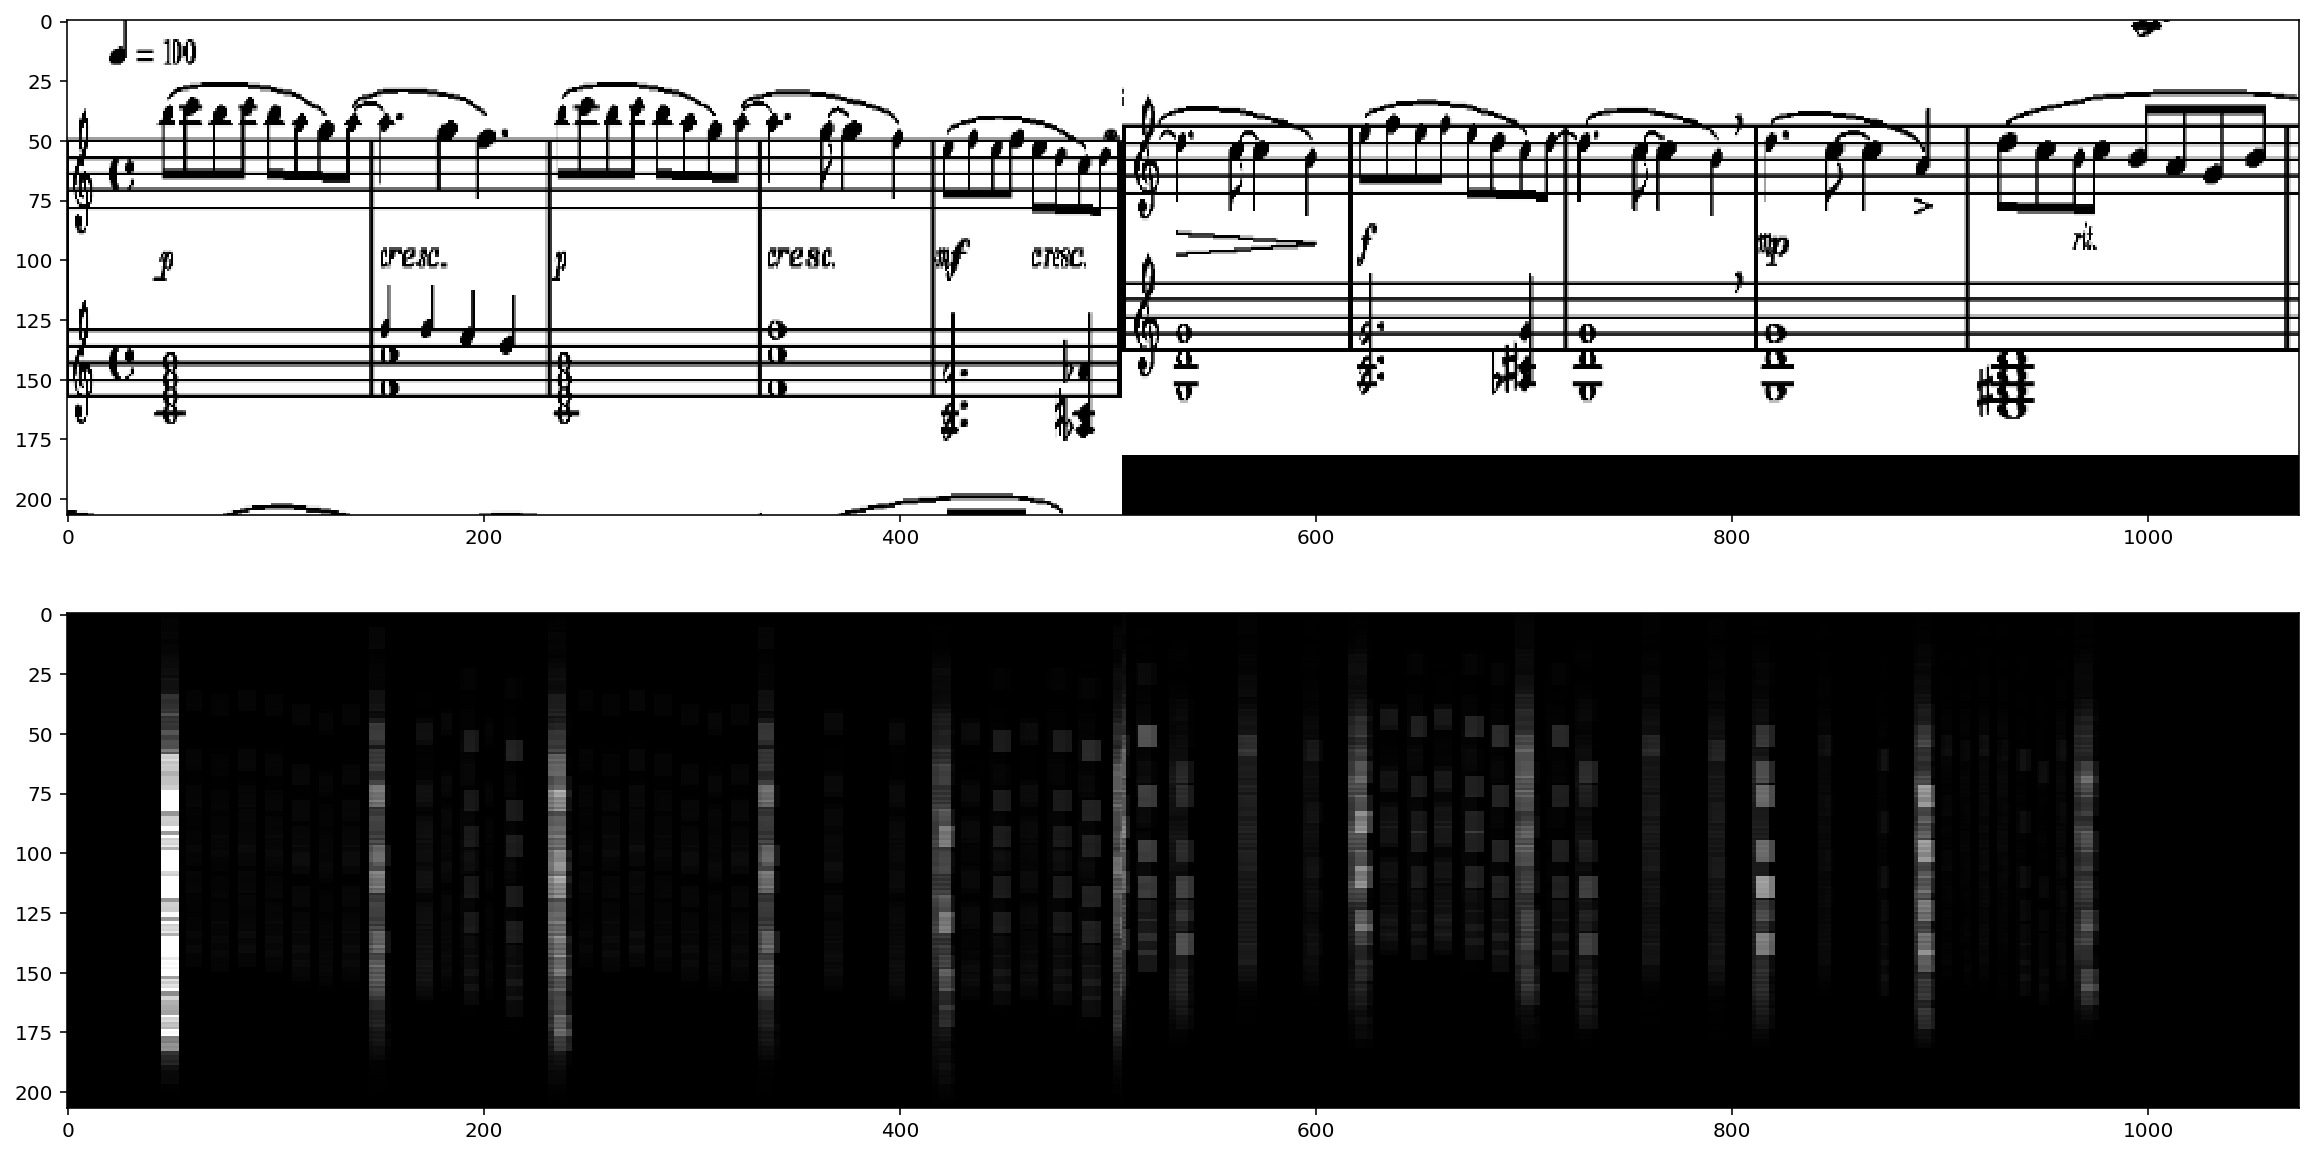

In [88]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(pan1, aspect='auto', cmap='gray')
plt.subplot(2,1,2)
plt.imshow(pan2, aspect='auto', cmap='gray')
plt.show()